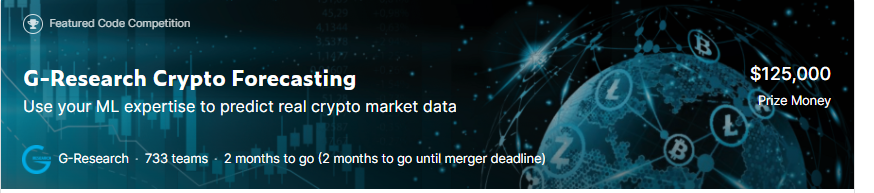

## 仮想通貨の過去の大量の取引データから、Targetを予測するコンペです。<br>
EDAはこちら。https://www.kaggle.com/tensorchoko/g-research-crypto-forecasting-eda-jp-en

## It is a competition to predict Target from a large amount of past transaction data of virtual currency. <br>
Click here for EDA. https://www.kaggle.com/tensorchoko/g-research-crypto-forecasting-eda-jp-en

 提出版は、REMOVE_LB_TEST_OVERLAPPING_DATA = Falseにする

For the submitted version, set REMOVE_LB_TEST_OVERLAPPING_DATA = False

### submit後に、とにかく時間がかかる。
### 高速化は初心者ながらやったつもり。

### After submitting, it takes time anyway.
### I think I did speeding up even though I was a beginner.

In [ ]:
#!pip -q install ../input/tabnet-install/pytorch_tabnet-3.1.1-py3-none-any.whl

In [ ]:
import os
import random
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
import lightgbm as lgb
import gresearch_crypto
import datetime
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetRegressor

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error as MSE
import warnings
warnings.filterwarnings('ignore')

TRAIN_CSV = '/kaggle/input/g-research-crypto-forecasting/train.csv'
ASSET_DETAILS_CSV = '/kaggle/input/g-research-crypto-forecasting/asset_details.csv'

SEED = 20

REMOVE_LB_TEST_OVERLAPPING_DATA = True

In [ ]:

!cp ../input/talibinstall/ta-lib-0.4.0-src.tar.gzh  ./ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz > null
!cd ta-lib && ./configure --prefix=/usr > null && make  > null && make install > null
!cp ../input/talibinstall/TA-Lib-0.4.21.tar.gzh TA-Lib-0.4.21.tar.gz
!pip install TA-Lib-0.4.21.tar.gz > null
!pip install ../input/talibinstall/numpy-1.21.4-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl >null
import talib as ta


In [ ]:
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

fix_all_seeds(SEED)

In [ ]:
df_train = pd.read_csv(TRAIN_CSV)
df_train

In [ ]:
df_test = pd.read_csv('../input/g-research-crypto-forecasting/example_test.csv')
df_test.head()

### データを直近のものだけにする　今は無効化

### Make the data only the latest one. Now disabled

In [ ]:
%%capture
'''
l =len(df_train)
l = l//2
df_train = df_train[l:].reset_index(drop=True)
df_train
'''

## Leakになるデータを外す。validデータを作る。

## Remove the data that becomes Leak. Create valid data.

In [ ]:
# Remove the future
if REMOVE_LB_TEST_OVERLAPPING_DATA:
    df_train['datetime'] = pd.to_datetime(df_train['timestamp'], unit='s')
    df_valid = df_train[(df_train['datetime'] > '2021-06-13 00:00:00')].reset_index(drop=True)
    df_train = df_train[(df_train['datetime'] < '2021-06-13 00:00:00')].reset_index(drop=True)
    #df_valid = df_train[(df_train['datetime'] > '2021-06-13 00:00:00') | (df_train['datetime'] < '2019-01-01 00:00:00')]
    #df_train = df_train[(df_train['datetime'] < '2021-06-13 00:00:00') | (df_train['datetime'] > '2019-01-01 00:00:00')]
    #print('delete data  ','train=',len(df_train),'  valid=',len(df_valid))
    df_train  = df_train.drop(['datetime'],axis=1)
    df_valid  = df_valid.drop(['datetime'],axis=1)
else:
    df_train['datetime'] = pd.to_datetime(df_train['timestamp'], unit='s')
    df_valid = df_train[(df_train['datetime'] > '2021-06-13 00:00:00')].reset_index(drop=True)
    df_train  = df_train.drop(['datetime'],axis=1)
    df_valid  = df_valid.drop(['datetime'],axis=1)


In [ ]:
df_valid = df_valid.dropna(subset=['Target']).reset_index(drop=True)
#bkup =df_valid.copy()

In [ ]:
df_asset_details = pd.read_csv(ASSET_DETAILS_CSV).sort_values("Asset_ID")
df_asset_details

## Feature Function を作る

## Make Feature Function

In [ ]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import accuracy_score
#!pip install optuna
import optuna 
import optuna.integration.lightgbm as lgbo

In [ ]:
def log_return(series, periods=5):
    return np.log(series).diff(periods=periods)

# Two features from the competition tutorial
def upper_shadow(df): return df['High'] - np.maximum(df['Close'], df['Open'])
def lower_shadow(df): return np.minimum(df['Close'], df['Open']) - df['Low']

# In Progress

### <u> いろいろこの変数を変えています。どうすれば最適か。すごくいいのができたら、このnotebookは非公開にする予定です。戦闘モードへ突入</u>

### <u> I am changing this variable in various ways. What should I do best? I plan to keep this notebook private when I can do something really good.Enter battle mode </u>

In [ ]:
def add_features(df):
    
    df["high_div_low"] = df["High"] / df["Low"]
    df["open_sub_close"] = df["Open"] - df["Close"]
    #df["open_sub_close2"] = df["Open"] / df["Close"] #
    df["open_sub_close_1"] = df["open_sub_close"].shift(-4)
    
    df['Open_shift-1'] = df['Open'].shift(-1)
    df['Open_shift-4'] = df['Open'].shift(-4)
    df['Open_shift-7'] = df['Open'].shift(-7)
    
    df['Open_shift1'] = df['Open'].shift(1)
    
    #df['Close_shift-1'] = df['Close'].shift(-1)
    
    df['close_log1'] = log_return(df['Close'],periods=1)
    df['close_log4'] = log_return(df['Close'],periods=4)
    #df['close_log7'] = log_return(df['Close'],periods=7)#
    
    #df['open_log1'] = log_return(df['Open'],periods=1)#
    
    #df['close_log4-1'] =df['close_log4'].shift(-1) #
    #df['avg5'] =  ta.SMA(df['Open'], timeperiod=5) #移動平均
    #df['avg25'] = ta.SMA(df['Open'], timeperiod=25) #df['Open'].rolling(25).mean()
    df['avg75'] = ta.SMA(df['Open'], timeperiod=75 )#df['Open'].rolling(75).mean()
    df['ema']   =ta.EMA(df['Open'], timeperiod=20) 
    df['willr'] = ta.WILLR(df['High'], df['Low'],np.array(df.loc[:, 'Close']), timeperiod=14)
    times = pd.to_datetime(df["timestamp"],unit="s",infer_datetime_format=True)
    df["hour"] = times.dt.hour  
    df["dayofweek"] = times.dt.dayofweek 
    df["day"] = times.dt.day 
    
    #df['RSI-9'] = ta.RSI(df['Close'], timeperiod=9)#
    df['RSI'] = ta.RSI(df['Close'], timeperiod=14)
    df['RSI1'] = df['RSI'].shift(-1)
    df['RSI4'] = df['RSI'].shift(-4)
    df['RSI7'] = df['RSI'].shift(-7)
    df['RSI10'] = df['RSI'].shift(-10)
    df['RSI13'] = df['RSI'].shift(-13) 
    df['RSI16'] = df['RSI'].shift(-16)  
    df['RSI~4'] = df['RSI'].shift(4)  #
    #df['RSI~7'] = df['RSI'].shift(7)  #
    #df['RSI+1'] = df['RSI'].shift(1)
    
    df['MACD'], df['macdsignal'], df['MACD_HIST'] = ta.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    #df['MACD1'] = df['MACD'].shift(-1)
    #df['MACD4'] = df['MACD'].shift(-4)
    #df['MACD7'] = df['MACD'].shift(-7)
    #df['MACD_HIST-4'] =df['MACD_HIST'].shift(4)# 
    df['MACD_HIST1'] =df['MACD_HIST'].shift(-1) 
    df['MACD_HIST4'] =df['MACD_HIST'].shift(-4) 
    df['MACD_HIST7'] =df['MACD_HIST'].shift(-7) 
    #df['MACD_HIST10'] =df['MACD_HIST'].shift(-10)#
    #df['u_bandx'], df['m_bandx'], df['l_bandx'] = ta.BBANDS(df['Close'], timeperiod=7, nbdevup=2, nbdevdn=2, matype=0)#
    
    df['u_band'], df['m_band'], df['l_band'] = ta.BBANDS(df['Close'], timeperiod=5, nbdevup=2, nbdevdn=2, matype=0) 
    df['adx'] = ta.ADX(df['High'], df['Low'],np.array(df.loc[:, 'Close']),timeperiod=14)
    df['adx1'] = df['adx'].shift(-1)
    df['adx4'] = df['adx'].shift(-4)
    df['adx+1'] = df['adx'].shift(1)
    #df['adx+2'] = df['adx'].shift(7)
    df['adx7'] = df['adx'].shift(-7)
    #df['adx10'] = df['adx'].shift(-10)#
    #df['adx+4'] = df['adx'].shift(4)
    #df['adx+1'] = df['adx'].shift(1)
    #df['adx7-12'] = ta.ADX(df['High'], df['Low'],np.array(df.loc[:, 'Close']),timeperiod=4) #
    
    df['macdsignal1'] = df['macdsignal'].shift(-1)
    df['macdsignal4'] = df['macdsignal'].shift(-4)
    df['macdsignal7'] = df['macdsignal'].shift(-7)
    #df['macdsignal10'] = df['macdsignal'].shift(-10) #
    
    df['DI_plus'] = ta.PLUS_DI(df['High'], df['Low'],np.array(df.loc[:, 'Close']), timeperiod=14)
    df['DI_minus'] = ta.MINUS_DI(df['High'], df['Low'],np.array(df.loc[:, 'Close']), timeperiod=14)
    
    #df = df.drop(['Close'],axis=1)
    #df['DI_plus1+1'] = df['DI_plus'].shift(1) #
    df['DI_plus1'] = df['DI_plus'].shift(-1)
    df['DI_plus4'] = df['DI_plus'].shift(-4)
    df['DI_plus7'] = df['DI_plus'].shift(-7) #いる
    df['DI_plus10'] = df['DI_plus'].shift(-10)
    
    df['DI_minus1'] = df['DI_minus'].shift(-1)
    df['DI_minus4'] = df['DI_minus'].shift(-4)
    df['DI_minus7'] = df['DI_minus'].shift(-7)
    #df['DI_minus10'] = df['DI_minus'].shift(-10) #
    
    df['ROCP'] =ta.ROCP(df['Open'])
    df['momentam'] =ta.MOM(df['Open'])
    
    df['APO'] =ta.APO(df['Open'])
    df['APO1'] = df['APO'].shift(-1)
    df['APO4'] = df['APO'].shift(-4)
    df['APO7'] = df['APO'].shift(-7) 
    
    df['PPO'] =ta.PPO(df['Open'])
    #df['PPO1'] = df['PPO'].shift(-1)
    #df['PPO4'] = df['PPO'].shift(-4)
    #df['PPO7'] = df['PPO'].shift(-7)
    #df['vwap-c'] =(1-np.exp(df['VWAP']))
    df = df.drop(['VWAP'],axis=1)

    df['CMO'] =ta.CMO(df['Open'])
    df['MIDPOINT'] =ta.MIDPOINT(df['Open'])
    #df['MIDPOINT1'] =df['MIDPOINT'].shift(-1)
    df['TRENDLINE'] =ta.HT_TRENDLINE(df['Open'])
    #df['TRENDLINE1']= df['TRENDLINE'].shift(-1)
    #df['timestamp1'] = df['timestamp'].shift(-1)
    return df 

In [ ]:
df_train

# TabNet under development

In [ ]:
   %%capture
    '''
    df = df_train #[df_train["Asset_ID"] == asset_id]
    df = df.dropna(subset=['Target'])
    
    y = df['Target'] 
    df      = df.drop(['Target','Asset_ID'],axis=1)
    #df_proc = get_features(df)
    df_proc = add_features(df)
    df_proc = df_proc.fillna(-1)
    X= df_proc #.drop("y", axis=1)
    
nunique = X.nunique()
types = X.dtypes

categorical_columns = []
categorical_dims =  {}

for col in df_test.columns:
    if  col == 'Asset_ID' :
        l_enc = LabelEncoder()
        X[col] = l_enc.fit_transform(X[col].values)
        X_test[col] = l_enc.transform(df_test[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
      if col != 'Target':
        scaler = StandardScaler()
        X[col] = scaler.fit_transform(X[col].values.reshape(-1, 1))
        df_test[col] = scaler.transform(X_test[col].values.reshape(-1, 1))
        


cat_idxs = [ i for i, f in enumerate(X.columns.tolist()) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(X.columns.tolist()) if f in categorical_columns]

tabnet_params1 = dict(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=1,
    n_d = 8, #16 8*3
    n_a = 8, #16
    n_steps = 2,
    gamma = 2,
    n_independent = 2,
    n_shared = 2,
    lambda_sparse = 0,#
    optimizer_fn = Adam,
    optimizer_params = dict(lr = (2e-2)),
    mask_type = "Target",
    scheduler_params = dict(T_0=220, T_mult=1, eta_min=1e-4, last_epoch=-1, verbose=False),
    scheduler_fn = CosineAnnealingWarmRestarts,
    seed = 77,
    verbose = 10
    
)

X_train,X_val,y_train,y_val = train_test_split(X.values, y.values.reshape(-1,1), test_size=0.2,random_state = 77)

   clf =  TabNetRegressor(**tabnet_params1)
    clf.fit(
      X_train, y_train,
      eval_set=[(X_val, y_val)],
      max_epochs = 100,
      patience = 5,#50
      batch_size = 1024*20, 
      virtual_batch_size = 128*20,
      num_workers = 4,
      drop_last = False,
      eval_metric=[RMSPE],
      loss_fn=RMSPELoss
      )
'''

In [ ]:
# Two new features from the competition tutorial
def upper_shadow(df):
    return df['High'] - np.maximum(df['Close'], df['Open'])

def lower_shadow(df):
    return np.minimum(df['Close'], df['Open']) - df['Low']

# A utility function to build features from the original df
# It works for rows to, so we can reutilize it.
def get_features(df_feat):
    #df_feat = df[['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP']].copy()
    df_feat['Upper_Shadow'] = upper_shadow(df_feat)
    df_feat['Lower_Shadow'] = lower_shadow(df_feat)
    return df_feat

def get_Xy_and_model_for_asset(df_train,asset_id):
    df = df_train[df_train["Asset_ID"] == asset_id]
    df = df.dropna(subset=['Target'])
    
    y = df['Target'] 
    df      = df.drop(['Target','Asset_ID'],axis=1)
    df_proc = get_features(df)
    df_proc = add_features(df_proc)
    df_proc = df_proc.fillna(-1)
    X= df_proc #.drop("y", axis=1)
    
    
    best_lgb_params ={'objective': 'regression',
    'metric': 'rmse',
    'feature_pre_filter': False,
    'lambda_l1': 0.010565309968664168,
    'lambda_l2': 0.3120057367604998,
    'num_leaves': 255,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'min_child_samples': 5}

    #best_lgb_params =model.params
    best_lgb_params["learning_rate"] = 0.01

    best_lgb_params["bagging_freq"] = 0
    best_lgb_params["device"] = 'gpu'
    best_lgb_params["early_stopping_round"] = 100
    best_lgb_params["num_iterations"] = 2000
    
    x_train,x_test,y_train,y_test = train_test_split(X, y, test_size=0.2,random_state = 77)
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_valid = lgb.Dataset(x_test, y_test)
     
    model = lgb.train(best_lgb_params,lgb_train, valid_sets=[lgb_valid], verbose_eval=100)
    
    #model = LGBMRegressor(n_estimators=1500,num_leaves=700,learning_rate=0.1,silent=True)
    #model.fit(X, y)
    
    #print( 'step3',datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))
    #fi =model.feature_importances_
    #fi_df = pd.DataFrame({'feature': list(X.columns),
    #     'feature importance': fi[:]}).sort_values('feature importance', ascending = False)
    #if asset_id ==0:
    #    display(fi_df)
    return model

## Training & Validation

In [ ]:
Xs = {}
ys = {}
models = {}

for asset_id, asset_name in zip(df_asset_details['Asset_ID'], df_asset_details['Asset_Name']):
    print(f"Training model for {asset_name:<16} (ID={asset_id:<2})   ",datetime.datetime.now().strftime('%Y/%m/%d %H:%M:%S'))
    
    model = get_Xy_and_model_for_asset(df_train, asset_id)    
    models[asset_id] =  model
    
    #validation
    x_pred = pd.DataFrame()
    x = asset_id
    record = df_valid[df_valid.Asset_ID == x]   
    target = record.Target 
    record = record.drop(['Target','Asset_ID'],axis=1)
    model = models[x]
    x_test = get_features(record)
    x_test = add_features(x_test) 
    #x_test = x_test.drop(['Asset_ID','Target'],axis=1)
        
    x_pred['x'] = model.predict(x_test)
    print('Test score for LR baseline: ', f"{np.corrcoef(x_pred.x, target)[0,1]:.5f}")
    #print('MSE=',MSE(x_pred.x, target))
    #print(x_pred.x[:10])
    #print(target[:10])
    del record
    del x_pred
    del x_test
    
    #break

# model save

In [ ]:
import pickle
with open('models','wb') as web:
    pickle.dump(models,web)

# Validation

### コイン毎ではなく、トータルのValidationスコアを計算します。

### Calculate the total Validation score, not per coin.

In [ ]:
    x_pred = pd.DataFrame()
    for x in range(len(df_valid.Asset_ID.unique())):
        print( 'Asset_ID=',x,' ',datetime.datetime.now().strftime('%Y年%m/%d/ %H:%M:%S'))
        record = df_valid[df_valid.Asset_ID == x]     
        record = record.drop(['Target','Asset_ID'],axis=1)
        model = models[x]
        x_test = get_features(record)
        x_test = add_features(pd.DataFrame(x_test)) #.values
        #x_test = x_test.drop(['Asset_ID','Target'],axis=1)

        x_test['y_pred'] = model.predict(x_test)
        x_pred = pd.concat([x_test,x_pred])    
    x_pred = x_pred.sort_index()    
    print(datetime.datetime.now().strftime('%Y/%m/%d %H:%M:%S'),'Test score for LR baseline: ', f"{np.corrcoef(x_pred.y_pred,df_valid.Target)[0,1]:.5f}")

# Predict & submit

In [ ]:
env = gresearch_crypto.make_env()
iter_test = env.iter_test()

for i, (df_test, df_pred) in enumerate(iter_test):
    #test = pd.DataFrame(index=(df_test['timestamp'].unique()))
    #df_test = get_features(df_test)
    
    #df_valid.set_index("timestamp",inplace=True) 
    #df_proc = df_proc.fillna(-1)
    #x_pred = pd.DataFrame()
    #timestamp= pd.DataFrame()
    for x in df_test.Asset_ID.unique():
        #print('Asset_Id=',x)
        model = models[x]
        x_test = df_test[df_test.Asset_ID == x]
        x_test = get_features(x_test)
        x_test = add_features(x_test)

        row_id = x_test.row_id
        x_test = x_test.drop(['row_id','Asset_ID'],axis=1)        
        #timestamp = data['timestamp']
        #row_id = data['row_id'].values
        
        #x_test = df_proc[df_proc.index.isin(data.timestamp.values)]
        
        #print('Asset_Id=',x,'  predict',len(x_test.columns),' ',x_test.columns)
        x_test['pred'] = model.predict(x_test)
        
        x_test['row_id'] =row_id
        #x_pred = pd.concat([x_pred,x_test])
      
        for j,row in x_test.iterrows():
            df_pred.loc[df_pred['row_id'] == row['row_id'], 'Target'] = row.pred
        
    #if x == 0:
    #    display(df_pred)
        
    env.predict(df_pred)

In [ ]:
df_test

In [ ]:
df_pred

## コイン事に予測していますが、果たしてそれが正しいのか疑問に思っています。

## I'm predicting coin, but I'm wondering if that's right.

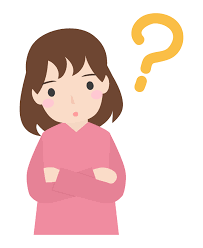

😺😅㊙🔰🗑⬛🟥🟨🟩